In [28]:
# imports
import pandas_datareader as pdr
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import statsmodels.api as smapi
import statsmodels.tsa as tsa
import numpy as np
import scipy as sp
import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [259]:
class DATA():
    # economic data
    
    @classmethod
    def get_commod_data(cls,*args,**kwargs):
        data = {'oil': cls.get_oil_data, 'gasoline':cls.get_gasoline_data,
                'natgas': cls.get_natgas_data, 'corn':cls.get_corn_data,
                'wheat':cls.get_wheat_data}
        
        results = {x: data[x](*args,**kwargs) for x in data.keys()}
        return results
    
    #commodities data
    @staticmethod
    def get_oil(*args,**kwargs):
        data = quandl.get("CHRIS/CME_QM1")
        return data
    @staticmethod
    def get_gasoline(*args,**kwargs):
        data = quandl.get("CHRIS/ICE_N1")
        return data
    @staticmethod
    def get_natgas(*args, **kwargs):
        data = quandl.get("CHRIS/CME_NG2")
    @staticmethod
    def get_corn(*args, **kwargs):
        data = quandl.get("CHRIS/LIFFE_EMA2")
        return data
    @staticmethod
    def get_wheat(*args, **kwargs):
        data = quandl.get("CHRIS/CME_W4")
        return data
    # Economic data
    @staticmethod
    def get_mich_cons_sent(*args, **kwargs):
        data = quandl.get('UMICH/SOC1')
        return data['Index']
    @staticmethod
    def get_fred_gdp(*args,**kwargs):
        data = quandl.get("FRED/GDP")
        return data
    # interest rate data
    @staticmethod
    def get_us_yields(*args,**kwargs):
        data = quandl.get("USTREASURY/YIELD")
        return data
    
class STATS():
    @staticmethod
    def Demean(data,*args,**kwargs):
        dem_data = data.subtract(data.mean())
        return dem_data
    
    @staticmethod
    def two_sample_test(data,*args,**kwargs):
        # method to split data into two equal half samples and run some simple comparisons to check for stationarity
        # note: it's very likely we will not be able to fully prove it but if we can get reasonably close it will save
        # us alot of work
        ndim = len(data)
        data_fh = data[:int(ndim/2)]
        data_sh =data[int(ndim/2):]
        mean_fh = data_fh.mean()
        mean_sh = data_sh.mean()
        var_fh = data_fh.var()
        var_sh = data_sh.var()
        # getting the 
        
        results = {'mu_fh':mean_fh,'mu_sh':mean_sh,'var_fh': var_fh, 'var_sh': var_sh}
        return pd.Series(results)
    
    @staticmethod
    def ADFuller(data,*args,**kwargs):
        # method to run augmented dickey-fuller test for unit-root
        # if we can reject the null our series is probably weakly stationary
        # the default is that the series is to run with a constant (i.e. non-zero mean)
        # but we can demean the series first
        # we can put a max-lag after the fact
        # note that lag convention is pythonic i.e. lag=0 means an AR(1)
        
        def_args = {}
        def_args['maxlag']=kwargs.get('maxlag',None)
        def_args['regression']=kwargs.get('regression','c')
        def_args['autolag']=kwargs.get('autolag','AIC')
        def_args['store']=kwargs.get('store',False)
        def_args['regresults']=kwargs.get('regresults',True)
        
        results = tsa.stattools.adfuller(data.values.reshape(-1,),**def_args)
        return results
    
    @staticmethod
    def compute_acf(data,*args,**kwargs):
        # return the sample autocorrelation function
        # by default return the confidence intervals
    
        def_args = {}
        def_args['unbiased']=kwargs.get('unbiased',False)
        def_args['nlags']=kwargs.get('nlags',36)
        def_args['qstat']=kwargs.get('qstat',False)
        def_args['alpha']=kwargs.get('alpha',0.05)
        
        results = tsa.stattools.acf(data,**def_args)
        return results
    
    @staticmethod
    def compute_pacf(data,*args,**kwargs):
        # return the sample autocorrelation function
        # by default return the confidence intervals
        def_args = {}
        def_args['nlags']=kwargs.get('nlags',36)
        def_args['method']=kwargs.get('method','ywunbiased')
        def_args['alpha']=kwargs.get('alpha',0.05)
        
        results = tsa.stattools.pacf(data,**def_args)
        return results
    
    @staticmethod
    def AR_model(data,*args,**kwargs):
        def_args = {}
        def_args['dates'] = kwargs.get('dates',None)
        def_args['freq'] = kwargs.get('freq',None)
        def_args['missing'] = kwargs.get('missing',None)
        model= tsa.ar_model.AR(data.values.reshape(-1,),**def_args)
        return model
                
    @staticmethod
    def ARMA_model(data,maxp=3,maxq=3,*args,**kwargs):
        plags=range(maxp+1)
        qlags=range(maxq+1)
        p_q = [(x,y) for x in plags for y in qlags]
        all_models = {'arma({0},{1})'.format(x[0],x[1]):tsa.arima_model.ARMA(data,x,) for x in p_q}
        return all_models
        
        
    @staticmethod
    def ARIMA_model(data,maxp=3,maxq=3,maxd=1,*args,**kwargs):
        plags=range(maxp+1)
        dlags=range(maxd+1)
        qlags=range(maxq+1)
        p_d_q = [(x,z,y) for x in plags for z in dlags for y in qlags]
        all_models = {'arima({0},{1},{2})'.format(x[0],x[1],x[2]):tsa.arima_model.ARIMA(endog=data,order=x,) for x in p_d_q}
        return all_models
        
    @staticmethod
    def SARIMA_model(data,maxp=3,maxq=3,maxd=1,maxP=0,maxD=0,maxQ=0,maxs=0,*args,**kwargs):
        plags=range(maxp+1)
        dlags=range(maxd+1)
        qlags=range(maxq+1)
        p_d_q = [(x,z,y) for x in plags for z in dlags for y in qlags]
        
        Plags=range(maxP+1)
        Dlags=range(maxD+1)
        Qlags=range(maxQ+1)
        slags=range(maxs+1)
        P_D_Q_s = [(a,b,c,d) for a in Plags for b in Dlags for c in Qlags for d in slags]
        
        all_models = {'sarima(({0},{1},{2})X({3},{4},{5},{6})'.format(x[0],x[1],x[2]):tsa.arima_model.SARIMAX(data,None,
                                                                                                              order=x,seasonal_order=y) 
                      for x in p_d_q for y in P_D_Q_s}

        
    
class PLOTTERS():
    @staticmethod
    def line_plot(data,xlabel=None,ylabel=None, *args,**kwargs):
        fig_ = plt.gcf()
        ax_ = data.plot()
        return fig_,ax_
        
        
        


##### Raw script

### Getting the data

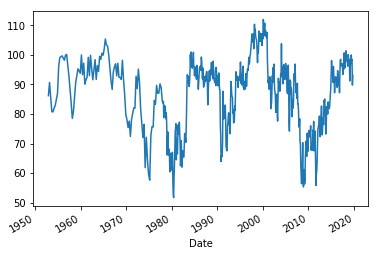

In [155]:
# Getting the the data
data_cons = DATA.get_mich_cons_sent()
data_cons.plot()

Notes: this is consumer sentiment data. The mean appears to be pretty stable and there are no obvious seasonal or trending patterns over the data

### Estimating and sample and partial ACFs

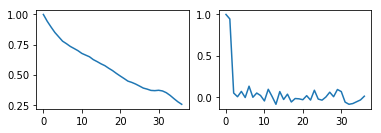

In [167]:
data_acf =STATS.compute_acf(data_cons)
data_pacf=STATS.compute_pacf(data_cons)
plt.subplot(221)
plt.plot(data_acf[0])
plt.subplot(222)
plt.plot(data_pacf[0])

Sample and partial autocorrelation functions plotted above. The sample autocorrelation suggests that there is persistence in the data but the PACF suggests that getting one lag incorporated reduces the other lags to near zero

### Stationarity test

In [169]:
simple_test = STATS.two_sample_test(data_cons)
# get up to two lags
adfuller_test_lag2 = STATS.ADFuller(data_cons,maxlag=2)
adfuller_fulltest = STATS.ADFuller(data_cons)

In [170]:
simple_test

mu_fh      84.696622
mu_sh      88.519192
var_fh    135.927311
var_sh    161.316286
dtype: float64

Notes: hard to tell much from this simple test. Probably will need to add some simple pair-mean / pair-variance tests but neither the means nor std. deviation look drastically different so this might suggest the data is near stationary - which is good!

In [174]:
adfuller_test_lag2

(-4.107012225598307,
 0.0009429963509191881,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 <statsmodels.tsa.stattools.ResultsStore at 0x1fac9078278>)

In [175]:
adfuller_fulltest

(-2.990084118137715,
 0.03583085276569507,
 {'1%': -3.4415393130846725,
  '5%': -2.866476335860869,
  '10%': -2.5693989358590006},
 <statsmodels.tsa.stattools.ResultsStore at 0x1fac90a49e8>)

Notes: this is decent result. A simple 2-lag (AR(3)) Augmented Dickey-Fuller test suggests that we can reject the null hypothesis that there is a unit root. A full test allowing the model to find the 'best-fit' suggests we can reject the null at 5% significance but not at 1% - so not definitive but it seems reasonable that the data is stationary

### Fitting an AR model

In [242]:
ddata_cons = STATS.Demean(data_cons)
# we don't actually have to demean since the code can do it but it seemed easier to visualize
ar_model_opt = STATS.AR_model(ddata_cons)
ar_fit = ar_model_opt.fit()
ar_model_1 = STATS.AR_model(ddata_cons)
ar_fit_1 = ar_model_0.fit(maxlag=1)

ar_model_2 = STATS.AR_model(ddata_cons)
ar_fit_2 = ar_model_2.fit(maxlag=2)

ar_model_3 = STATS.AR_model(ddata_cons)
ar_fit_3 = ar_model_3.fit(maxlag=3)

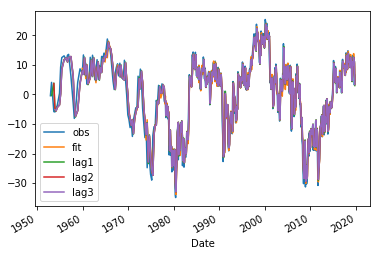

In [243]:
fitvalues = pd.Series(index=ddata_cons.index[19:],data=ar_fit.fittedvalues)
fitvalues_1 = pd.Series(index=ddata_cons.index[1:],data=ar_fit_1.fittedvalues)
fitvalues_2 = pd.Series(index=ddata_cons.index[2:],data=ar_fit_2.fittedvalues)
fitvalues_3 = pd.Series(index=ddata_cons.index[3:],data=ar_fit_3.fittedvalues)

plot_data = pd.DataFrame({'obs':ddata_cons,'fit':fitvalues, 'lag1':fitvalues_1,
                         'lag2':fitvalues_2,'lag3':fitvalues_3})
plot_data.plot()

In [244]:
print('opt:{0} lag1:{1} lag2:{2} lag3:{3}'.format(ar_fit.aic,ar_fit_1.aic,ar_fit_2.aic,ar_fit_3.aic))

opt:2.806249023448857 lag1:2.8176630066590973 lag2:2.8186956972423496 lag3:2.8144416295185195


An AR model seems to fit pretty well. The optimal fit found by minimizing the AIC appears to choose up to 20 lags. But even 1 lag seems to get pretty close.

### Fitting ARMA model

In [246]:
# this gets all the arma models
# we then have to fit each one and get the AIC
all_arma = STATS.ARMA_model(ddata_cons,maxp=5,maxq=1)
arma_aic = pd.Series({imodel: all_arma[imodel].fit().aic for imodel in all_arma})


In [247]:
arma_aic

arma(0,0)    4665.221752
arma(0,1)    4128.747800
arma(1,0)    3354.933739
arma(1,1)    3355.710443
arma(2,0)    3355.738320
arma(2,1)    3354.360791
arma(3,0)    3357.693900
arma(3,1)    3355.473984
arma(4,0)    3357.026616
arma(4,1)    3355.954246
arma(5,0)    3359.010548
arma(5,1)    3357.953454
dtype: float64

In [249]:
opt_model=all_arma['arma(2,1)'].fit()

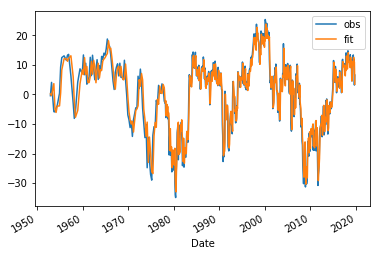

In [252]:
plot_data = pd.DataFrame({'obs': ddata_cons, 'fit':opt_model.fittedvalues})
plot_data.plot()

Notes: An ARMA(2,1) seems to be the optimal fit but it's likely a pretty flat surface. One problem I'm noticing is that attemps to do more than a MA(1) seem to be problematic i.e. the optimizer doesn't converge with current defaults. We can try to increase the number of iterations but it might not be worth it.

### Fitting ARIMA model

In [268]:
# this gets all the arima models
# we then have to fit each one and get the AIC
all_arima = STATS.ARIMA_model(ddata_cons,maxp=5,maxq=1,maxd=1)
arima_aic = pd.Series({imodel: all_arima[imodel].fit().aic for imodel in all_arima})


In [269]:
arima_aic

arima(0,0,0)    4665.221752
arima(0,0,1)    4128.747800
arima(0,1,0)    3362.767034
arima(0,1,1)    3361.481192
arima(1,0,0)    3354.933739
arima(1,0,1)    3355.710443
arima(1,1,0)    3361.728368
arima(1,1,1)    3351.002873
arima(2,0,0)    3355.738320
arima(2,0,1)    3354.360791
arima(2,1,0)    3363.057930
arima(2,1,1)    3352.962195
arima(3,0,0)    3357.693900
arima(3,0,1)    3355.473984
arima(3,1,0)    3360.285071
arima(3,1,1)    3353.494906
arima(4,0,0)    3357.026616
arima(4,0,1)    3355.954246
arima(4,1,0)    3362.139767
arima(4,1,1)    3355.460171
arima(5,0,0)    3359.010548
arima(5,0,1)    3357.953454
arima(5,1,0)    3351.599553
arima(5,1,1)    3353.097862
dtype: float64

In [270]:
arima_aic.min()

3351.0028725097827

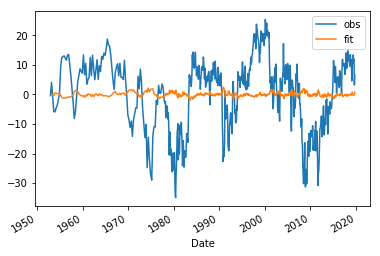

In [272]:
optarima = all_arima['arima(1,1,1)'].fit()
plot_data = pd.DataFrame({'obs': ddata_cons, 'fit':optarima.fittedvalues})
# the plot is definitely wrong
# I don't think the fittedvalues attribute for ARIMA models is correct
# no documentation on it
optarima.

plot_data.plot()

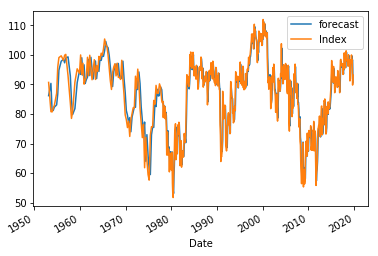

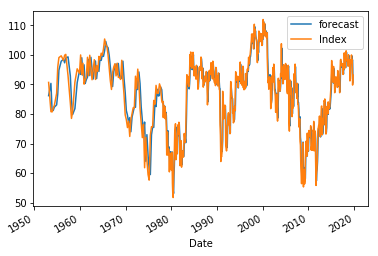

In [273]:
optarima.plot_predict()

Notes: ok.. so for ARIMA models (and probably SARIMA which I won't do yet) we want to use the built in plot-predict function.
We should compare the three model types by mean-square error. It all looks really close so I doubt we'll have a clear winner.